## Modifying Residual Connections

Testing code for accessing the representation at a given layer **before applying the residual connection**.


In [144]:
import torch
from transformers import BertModel, BertConfig, BertTokenizer
from transformers.models.bert.modeling_bert import BertLayer
from transformers.modeling_outputs import BaseModelOutputWithPoolingAndCrossAttentions


import torch
import torch.nn as nn
from transformers import BertConfig

from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
import pandas as pd
import seaborn as sns

from tqdm import tqdm

## ChatGPT Version

In [57]:
#### ChatGPT version
# Define a custom model class
class CustomBertModel(BertModel):
    def __init__(self, config):
        super().__init__(config)
    
    def forward(self, *args, **kwargs):
        # Call the original forward method to get the standard outputs
        outputs = super().forward(*args, **kwargs)
        
        # Extract hidden states from the original forward pass
        hidden_states = outputs.hidden_states  # List of hidden states at each layer
        
        # Lists to store pre-residual and post-residual outputs of each layer
        pre_residual_outputs = []
        post_residual_outputs = []
        
        # Iterate through each layer to compute pre-residual and post-residual outputs
        for i, layer in enumerate(self.encoder.layer):
            # Compute self-attention output (before adding residual connection)
            self_attention_outputs = layer.attention(hidden_states[i], output_attentions=False)
            attention_output = self_attention_outputs[0]
            pre_residual_attention_output = attention_output  # Save pre-residual attention output
            
            # Apply attention output with residual connection and normalization
            attention_output = layer.attention.output.LayerNorm(attention_output + hidden_states[i])
            
            # Compute feedforward output (before adding residual connection)
            intermediate_output = layer.intermediate(attention_output)
            layer_output = layer.output.dense(intermediate_output)
            pre_residual_layer_output = layer_output  # Save pre-residual layer output
            
            # Apply feedforward output with residual connection and normalization
            layer_output = layer.output.LayerNorm(layer_output + attention_output)
            
            # Store the pre-residual and post-residual outputs
            pre_residual_outputs.append(pre_residual_layer_output)
            post_residual_outputs.append(layer_output)
        
        # Return the standard outputs, pre-residual outputs, and post-residual outputs
        return outputs, pre_residual_outputs, post_residual_outputs

# Load the pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = CustomBertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# Tokenize the input text
input_text = "Hello, how are you?"
inputs = tokenizer(input_text, return_tensors='pt')

# Forward pass
outputs, pre_residual_outputs, post_residual_outputs = model(**inputs)

# Extract the post-residual outputs and hidden states for a specific layer
layer_index = 5  # Example layer index
post_residual_layer_output = post_residual_outputs[layer_index][0]
pre_residual_layer_output = pre_residual_outputs[layer_index][0]
hidden_state_layer_output = outputs.hidden_states[layer_index + 1][0]  # hidden_states includes embedding layer as the first element

# Compare the post-residual outputs to the hidden states
print("Post-Residual Output for Layer", layer_index)
print(post_residual_layer_output)

print("\nHidden State Output for Layer", layer_index)
print(hidden_state_layer_output)

# Check if they are equal
print("\nAre the outputs equal?", torch.allclose(post_residual_layer_output, hidden_state_layer_output, atol=1e-6))

# Also print the pre-residual output for clarity
print("\nPre-Residual Output for Layer", layer_index)
print(pre_residual_layer_output)

Post-Residual Output for Layer 5
tensor([[ 0.0367, -0.3417, -0.3950,  ...,  0.0788,  0.1991,  0.3832],
        [ 0.9718,  0.1975,  0.7590,  ...,  0.6820,  0.1647, -0.4499],
        [ 0.1348,  0.4053,  0.0572,  ..., -0.2338, -0.1639,  0.6239],
        ...,
        [-0.2164, -1.4882,  0.8183,  ..., -0.1463, -0.0400,  0.0578],
        [ 0.3149, -0.7261, -0.5962,  ...,  0.0103,  0.0065,  0.6139],
        [ 0.0138, -0.0125, -0.0064,  ...,  0.0026, -0.0205, -0.0142]],
       grad_fn=<SelectBackward0>)

Hidden State Output for Layer 5
tensor([[ 0.0839, -0.9179, -0.5961,  ...,  0.0639,  0.3273,  0.3681],
        [ 0.7318, -0.1368,  1.1241,  ...,  0.6588, -0.2409, -0.5797],
        [-0.1293,  0.5957,  0.2409,  ..., -0.5293, -0.3646,  0.5766],
        ...,
        [-0.3583, -1.9956,  0.9719,  ..., -0.1385,  0.1476, -0.3508],
        [ 0.3562, -1.0461, -0.9223,  ...,  0.0445, -0.2199,  0.5077],
        [ 0.0170, -0.0387, -0.0153,  ...,  0.0079, -0.0167, -0.0436]],
       grad_fn=<SelectBackward0>

In [58]:
# Compute the overall correlation between the two tensors using scipy
post_residual_flat = post_residual_layer_output.flatten().detach().numpy()
hidden_state_flat = hidden_state_layer_output.flatten().detach().numpy()

correlation, _ = pearsonr(post_residual_flat, hidden_state_flat)
print("Pearson Correlation between the post/hidden tensors:", correlation)

pre_residual_flat = pre_residual_layer_output.flatten().detach().numpy()

correlation, _ = pearsonr(pre_residual_flat, hidden_state_flat)
print("Pearson Correlation between the pre/hidden tensors:", correlation)

correlation, _ = pearsonr(pre_residual_flat, post_residual_flat)
print("Pearson Correlation between the pre/post tensors:", correlation)

Pearson Correlation between the post/hidden tensors: 0.9362243522476544
Pearson Correlation between the pre/hidden tensors: 0.281897231078784
Pearson Correlation between the pre/post tensors: 0.2666938847810285


In [59]:
# Check if the two tensors have the same sign for each element
same_sign = torch.sign(post_residual_layer_output) == torch.sign(hidden_state_layer_output)

# Compute the proportion of elements with the same sign
proportion_same_sign = torch.mean(same_sign.float())
print("Proportion of post/hidden elements with Same Sign:", proportion_same_sign.item())

same_sign = torch.sign(pre_residual_layer_output) == torch.sign(hidden_state_layer_output)

# Compute the proportion of elements with the same sign
proportion_same_sign = torch.mean(same_sign.float())
print("Proportion of pre/hidden elements with Same Sign:", proportion_same_sign.item())

same_sign = torch.sign(pre_residual_layer_output) == torch.sign(post_residual_layer_output)

# Compute the proportion of elements with the same sign
proportion_same_sign = torch.mean(same_sign.float())
print("Proportion of pre/post elements with Same Sign:", proportion_same_sign.item())

Proportion of post/hidden elements with Same Sign: 0.8889973759651184
Proportion of pre/hidden elements with Same Sign: 0.60009765625
Proportion of pre/post elements with Same Sign: 0.6072590947151184


## Claude Version

In [62]:
class CustomBertModel(BertModel):
    def __init__(self, config):
        super().__init__(config)
    
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        # Call the original forward method to get the standard outputs
        outputs = super().forward(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            output_hidden_states=True,  # Enable output of all hidden states
        )
        
        # Extract hidden states from the original forward pass
        hidden_states = outputs.hidden_states  # List of hidden states at each layer
        
        # Lists to store pre-residual and post-residual outputs of each layer
        pre_residual_outputs = []
        post_residual_outputs = []
        
        # Iterate through each layer to compute pre-residual and post-residual outputs
        for i, layer in enumerate(self.encoder.layer):
            # Compute self-attention output (before adding residual connection)
            self_attention_outputs = layer.attention(hidden_states[i], attention_mask, head_mask[i] if head_mask is not None else None, output_attentions=False)
            attention_output = self_attention_outputs[0]
            
            # Apply attention output with residual connection and normalization
            attention_output = layer.attention.output.LayerNorm(attention_output + hidden_states[i])
            
            # Compute feedforward output (before adding residual connection)
            intermediate_output = layer.intermediate(attention_output)
            layer_output = layer.output.dense(intermediate_output)
            pre_residual_layer_output = layer_output  # Save pre-residual layer output
            
            # Apply feedforward output with residual connection and normalization
            layer_output = layer.output.LayerNorm(layer_output + attention_output)
            
            # Store the pre-residual and post-residual outputs
            pre_residual_outputs.append(pre_residual_layer_output)
            post_residual_outputs.append(layer_output)
        
        # Create a new output object with all the original outputs plus our new pre_residual and post_residual outputs
        new_outputs = BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=outputs.last_hidden_state,
            pooler_output=outputs.pooler_output,
            hidden_states=outputs.hidden_states,
            past_key_values=outputs.past_key_values,
            attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )
        
        new_outputs.pre_residual_outputs = pre_residual_outputs
        new_outputs.post_residual_outputs = post_residual_outputs

        return new_outputs



In [63]:
# Usage example
config = BertConfig.from_pretrained('bert-base-uncased')
model = CustomBertModel.from_pretrained('bert-base-uncased', config=config)

# Forward pass
input_ids = torch.tensor([[1, 2, 3, 4, 5]])
outputs = model(input_ids)



In [64]:
# Compare outputs
def compare_outputs(layer_idx):
    pre_residual = outputs.pre_residual_outputs[layer_idx]
    post_residual = outputs.post_residual_outputs[layer_idx]
    current_hidden_state = outputs.hidden_states[layer_idx]  # This is the input to the current layer
    next_hidden_state = outputs.hidden_states[layer_idx + 1]  # This is the output of the current layer

    # Compute the overall correlation between the two tensors using scipy
    post_residual_flat = post_residual.flatten().detach().numpy()
    next_hidden_state_flat = next_hidden_state.flatten().detach().numpy()
    current_hidden_state_flat = current_hidden_state.flatten().detach().numpy()
    pre_residual_flat = pre_residual.flatten().detach().numpy()
    
    post_next_hidden_correlation, _ = pearsonr(post_residual_flat, next_hidden_state_flat)
    post_current_hidden_correlation, _ = pearsonr(post_residual_flat, current_hidden_state_flat)
    pre_post_correlation, _ = pearsonr(post_residual_flat, pre_residual_flat)
    pre_next_hidden_correlation, _ = pearsonr(pre_residual_flat, next_hidden_state_flat)
    pre_current_hidden_correlation, _ = pearsonr(pre_residual_flat, current_hidden_state_flat)
    next_current_hidden_correlation, _ = pearsonr(current_hidden_state_flat, next_hidden_state_flat)

    return {
        'post_nexth': post_next_hidden_correlation,
        'post_currenth': post_current_hidden_correlation,
        'pre_post': pre_post_correlation,
        'pre_nexth': pre_next_hidden_correlation,
        'pre_currenth': pre_current_hidden_correlation,
        'nexth_currenth': next_current_hidden_correlation,
        'layer': layer_idx
    }

In [65]:
results = []
for i in range(12):

    res = compare_outputs(i)
    results.append(res)

In [66]:
df = pd.DataFrame(results)
df_melted = pd.melt(df, var_name = "Variables", value_name = "Correlation", id_vars = "layer")

In [67]:
df_melted['var1'] = df_melted['Variables'].apply(lambda x: x.split("_")[0])
df_melted['var2'] = df_melted['Variables'].apply(lambda x: x.split("_")[1])

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with 

<Axes: xlabel='layer', ylabel='Correlation'>

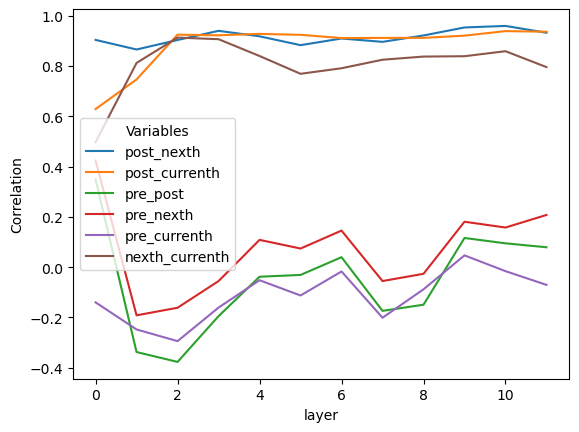

In [68]:
sns.lineplot(data = df_melted, x = "layer", y = "Correlation", hue = "Variables")

## New version

In [127]:
class CustomBertModel(BertModel):
    def __init__(self, config):
        super().__init__(config)
    
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        # Ensure attention mask is of the correct dtype
        if attention_mask is not None:
            attention_mask = attention_mask.to(dtype=torch.float)
        
        # Call the original forward method to get the standard outputs
        outputs = super().forward(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            output_hidden_states=True,  # Enable output of all hidden states
        )
        
        # Extract hidden states from the original forward pass
        hidden_states = outputs.hidden_states  # List of hidden states at each layer
        
        # Lists to store the required states at each layer
        post_attention_pre_residual_1 = []
        post_attention_post_residual_1 = []
        post_ffn_pre_residual_2 = []
        post_ffn_post_residual_2 = []
        
        # Iterate through each layer to compute and store the required states
        for i, layer in enumerate(self.encoder.layer):
            # Compute self-attention output (before adding residual connection)
            self_attention_outputs = layer.attention(hidden_states[i], attention_mask, head_mask[i] if head_mask is not None else None, output_attentions=False)
            attention_output = self_attention_outputs[0]
            
            # Save the post-attention, pre-residual connection 1 state
            post_attention_pre_residual_1.append(attention_output)
            
            # Apply attention output with residual connection and normalization
            attention_output = layer.attention.output.LayerNorm(attention_output + hidden_states[i])
            
            # Save the post-attention, post-residual connection 1 (but before FFN) state
            post_attention_post_residual_1.append(attention_output)
            
            # Compute feedforward output (before adding residual connection)
            intermediate_output = layer.intermediate(attention_output)
            layer_output = layer.output.dense(intermediate_output)
            
            # Save the post-FFN, but pre-residual connection 2 state
            post_ffn_pre_residual_2.append(layer_output)
            
            # Apply feedforward output with residual connection and normalization
            layer_output = layer.output.LayerNorm(layer_output + attention_output)
            
            # Save the post-FFN and post-residual connection 2 state
            post_ffn_post_residual_2.append(layer_output)
        
        # Create a new output object with all the original outputs plus our new states
        new_outputs = BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=outputs.last_hidden_state,
            pooler_output=outputs.pooler_output,
            hidden_states=outputs.hidden_states,
            past_key_values=outputs.past_key_values,
            attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )
        
        # Add the new states to the output
        new_outputs.post_attention_pre_residual_1 = post_attention_pre_residual_1
        new_outputs.post_attention_post_residual_1 = post_attention_post_residual_1
        new_outputs.post_ffn_pre_residual_2 = post_ffn_pre_residual_2
        new_outputs.post_ffn_post_residual_2 = post_ffn_post_residual_2

        return new_outputs

In [191]:
# Usage example
config = BertConfig.from_pretrained('bert-base-uncased')
model = CustomBertModel.from_pretrained('bert-base-uncased', config=config)

# Forward pass
input_ids = torch.tensor([[1, 2, 3, 4, 5]])
outputs = model(input_ids)



/Users/seantrott/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [188]:
def compare_outputs(outputs, layer_idx):
    post_attention_pre_residual_1 = outputs.post_attention_pre_residual_1[layer_idx]
    post_attention_post_residual_1 = outputs.post_attention_post_residual_1[layer_idx]
    post_ffn_pre_residual_2 = outputs.post_ffn_pre_residual_2[layer_idx]
    post_ffn_post_residual_2 = outputs.post_ffn_post_residual_2[layer_idx]
    
    current_hidden_state = outputs.hidden_states[layer_idx]  # This is the input to the current layer
    next_hidden_state = outputs.hidden_states[layer_idx + 1]  # This is the output of the current layer

    # Flatten tensors and convert to numpy arrays for correlation computation
    post_attention_pre_residual_1_flat = post_attention_pre_residual_1.flatten().detach().numpy()
    post_attention_post_residual_1_flat = post_attention_post_residual_1.flatten().detach().numpy()
    post_ffn_pre_residual_2_flat = post_ffn_pre_residual_2.flatten().detach().numpy()
    post_ffn_post_residual_2_flat = post_ffn_post_residual_2.flatten().detach().numpy()
    current_hidden_state_flat = current_hidden_state.flatten().detach().numpy()
    next_hidden_state_flat = next_hidden_state.flatten().detach().numpy()
    
    # Compute correlations
    def compute_correlation(tensor1, tensor2):
        return pearsonr(tensor1, tensor2)[0]
    
    correlations = {
        'post_attention_pre_residual_1_next_hidden': compute_correlation(post_attention_pre_residual_1_flat, next_hidden_state_flat),
        'post_attention_pre_residual_1_current_hidden': compute_correlation(post_attention_pre_residual_1_flat, current_hidden_state_flat),
        'post_attention_post_residual_1_next_hidden': compute_correlation(post_attention_post_residual_1_flat, next_hidden_state_flat),
        'post_attention_post_residual_1_current_hidden': compute_correlation(post_attention_post_residual_1_flat, current_hidden_state_flat),
        'post_ffn_pre_residual_2_next_hidden': compute_correlation(post_ffn_pre_residual_2_flat, next_hidden_state_flat),
        'post_ffn_pre_residual_2_current_hidden': compute_correlation(post_ffn_pre_residual_2_flat, current_hidden_state_flat),
        'post_ffn_post_residual_2_next_hidden': compute_correlation(post_ffn_post_residual_2_flat, next_hidden_state_flat),
        'post_ffn_post_residual_2_current_hidden': compute_correlation(post_ffn_post_residual_2_flat, current_hidden_state_flat),
        'current_hidden_next_hidden': compute_correlation(current_hidden_state_flat, next_hidden_state_flat),
        'layer': layer_idx
    }

    return correlations

In [130]:
results = []
for i in range(12):

    res = compare_outputs(outputs, i)
    results.append(res)

In [131]:
df = pd.DataFrame(results)
df_melted = pd.melt(df, var_name = "Variables", value_name = "Correlation", id_vars = "layer")

In [132]:
df_melted['var1'] = df_melted['Variables'].apply(lambda x: x.split("_")[0])
df_melted['var2'] = df_melted['Variables'].apply(lambda x: x.split("_")[1])

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with 

<Axes: xlabel='layer', ylabel='Correlation'>

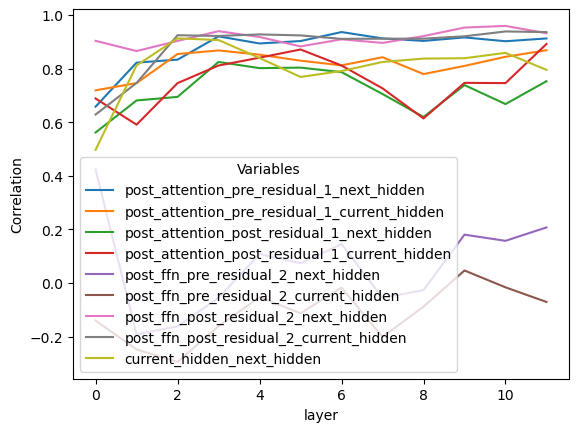

In [133]:
sns.lineplot(data = df_melted, x = "layer", y = "Correlation", hue = "Variables")

### Compare to original `BertModel`

Just to make sure we're not messing up the hidden states.

In [134]:
import transformers

In [135]:
model2 = transformers.AutoModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# Forward pass
input_ids = torch.tensor([[1, 2, 3, 4, 5]])
outputs2 = model2(input_ids, )


In [136]:
hs1 = outputs.hidden_states
hs2 = outputs2.hidden_states

In [137]:
for i in range(len(hs1)):

    o1_hs = hs1[i].flatten().detach().numpy()
    o2_hs = hs2[i].flatten().detach().numpy()
    r = pearsonr(o1_hs, o2_hs)[0]
    print(r)

1.0
1.0
1.0
1.0
0.9999999999999987
0.9999999999999969
1.0
0.9999999999999992
1.0
1.0
1.0
1.0
1.0


### New helper functions

In [211]:
import functools
import torch

### ... find the target tokens within tokenized sequence
def find_sublist_index(mylist, sublist):
    """Find the first occurrence of sublist in list.
    Return the start and end indices of sublist in list"""
    for i in range(len(mylist)):
        if mylist[i] == sublist[0] and mylist[i:i+len(sublist)] == sublist:
            return i, i+len(sublist)
    return None

@functools.lru_cache(maxsize=None)  # This will cache results, handy later...

### ... grab the embeddings for your target tokens
def get_embeddings(model, tokenizer, sentence, target, layer, device):
    """Get token embeddings for target in sentence at a specific layer"""
    
    # Tokenize sentence
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    
    # Tokenize target
    target_enc = tokenizer.encode(target, return_tensors="pt",
                                  add_special_tokens=False).to(device)
    
    # Get indices of target in input tokens
    target_inds = find_sublist_index(
        inputs["input_ids"][0].tolist(),
        target_enc[0].tolist()
    )

    # Run model
    with torch.no_grad():
        output = model(**inputs)
        
    # Extract the required embeddings
    post_attention_pre_residual_1 = output.post_attention_pre_residual_1[layer][0]
    post_attention_post_residual_1 = output.post_attention_post_residual_1[layer][0]
    post_ffn_pre_residual_2 = output.post_ffn_pre_residual_2[layer][0]
    post_ffn_post_residual_2 = output.post_ffn_post_residual_2[layer][0]

    current_hidden_state = output.hidden_states[layer][0]
    
    # Extract the token embeddings for the target word's tokens
    
    token_embeddings_post_attention_pre_residual_1 = post_attention_pre_residual_1[target_inds[0]:target_inds[1]]
    token_embeddings_post_attention_post_residual_1 = post_attention_post_residual_1[target_inds[0]:target_inds[1]]
    token_embeddings_post_ffn_pre_residual_2 = post_ffn_pre_residual_2[target_inds[0]:target_inds[1]]
    token_embeddings_post_ffn_post_residual_2 = post_ffn_post_residual_2[target_inds[0]:target_inds[1]]
    token_embeddings_current_hidden_state = current_hidden_state[target_inds[0]:target_inds[1]]

    # Compute the mean embeddings if a word is represented by >1 tokens
    embedding_post_attention_pre_residual_1 = torch.mean(token_embeddings_post_attention_pre_residual_1, dim=0)
    embedding_post_attention_post_residual_1 = torch.mean(token_embeddings_post_attention_post_residual_1, dim=0)
    embedding_post_ffn_pre_residual_2 = torch.mean(token_embeddings_post_ffn_pre_residual_2, dim=0)
    embedding_post_ffn_post_residual_2 = torch.mean(token_embeddings_post_ffn_post_residual_2, dim=0)
    embedding_current_hidden_state = torch.mean(token_embeddings_current_hidden_state, dim=0)
    
    return {
        'post_attention_pre_residual_1': embedding_post_attention_pre_residual_1,
        'post_attention_post_residual_1': embedding_post_attention_post_residual_1,
        'post_ffn_pre_residual_2': embedding_post_ffn_pre_residual_2,
        'post_ffn_post_residual_2': embedding_post_ffn_post_residual_2,
        'current_hidden_state': embedding_current_hidden_state}

In [212]:
def count_parameters(model):
    """credit: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model"""
    
    total_params = 0
    for name, parameter in model.named_parameters():
        
        # if the param is not trainable, skip it
        if not parameter.requires_grad:
            continue
        
        # otherwise, count it towards your number of params
        params = parameter.numel()
        total_params += params
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

In [213]:
def get_cosine_distance(tensor1, tensor2, device):
    if device.type == "mps":
        return cosine(tensor1.cpu(), tensor2.cpu())
    else:
        return cosine(tensor1, tensor2)

### Rerun RAW-C

In [251]:
df_rawc = pd.read_csv("../data/raw/rawc/rawc_stimuli.csv")
df_rawc.head(2)

,word,sentence1,sentence2,same,ambiguity_type,Class,mean_relatedness,string
0,act,It was a desperate act.,It was a magic act.,False,Polysemy,N,2.181818,act
1,act,It was a desperate act.,It was a comedic act.,False,Polysemy,N,2.000000,act


In [252]:
### Load custombert
mpath = 'bert-base-uncased'
model = CustomBertModel.from_pretrained(mpath, config=config)

In [253]:
### Decide which device you want the models to run in

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### Load your model & tokenizer

model.to(device) # allocate model to desired device

tokenizer = transformers.AutoTokenizer.from_pretrained(mpath)  


### Get the number of layers & params directly from the model specifications

n_layers = model.config.num_hidden_layers
print("number of layers:", n_layers)

n_params = count_parameters(model)

results = []

for layer in range(n_layers+1): # `range` is non-inclusive for the last value of interval
    for (ix, row) in tqdm(df_rawc.iterrows(), total=df_rawc.shape[0]):

        ### Get embeddings for S1 and S2

        # note: account for tokenization differences in RoBERTa Spanish monolinguals  by
        #.      adding a whitespace in front of the target word (otherwise, the function
        #.      `find_sublist_index` will not be able to identify the target token-s within
        #.      the tokenized sentence)
        
        if mpath in ["FacebookAI/roberta-large", "FacebookAI/roberta-base"]:
            target = " {w}".format(w = row['string'])
        else:
            target = row['string']

        # Get embeddings for each word/context
        e1 = get_embeddings(model, tokenizer, row['sentence1'], target, layer, device)
        e2 = get_embeddings(model, tokenizer, row['sentence2'], target, layer, device)
        
        cosine_distances = {

        }


        if row['same'] == True:
            same_sense = "Same Sense"
        else:
            same_sense = "Different Sense"


        ### Figure out how many tokens you're
        ### comparing across sentences
        n_tokens_s1 = len(tokenizer.encode(row['sentence1']))
        n_tokens_s2 = len(tokenizer.encode(row['sentence2']))

        ### Add to results dictionary
        results.append({
            'sentence1': row['sentence1'],
            'sentence2': row['sentence2'],
            'word': row['word'],
            'string': row['string'],
            'Same_sense': row['same'],
            'distance_post_attention_pre_residual_1': get_cosine_distance(e1['post_attention_pre_residual_1'], e2['post_attention_pre_residual_1'], device),
            'distance_post_attention_post_residual_1': get_cosine_distance(e1['post_attention_post_residual_1'], e2['post_attention_post_residual_1'], device),
            'distance_post_ffn_pre_residual_2': get_cosine_distance(e1['post_ffn_pre_residual_2'], e2['post_ffn_pre_residual_2'], device),
            'distance_post_ffn_post_residual_2': get_cosine_distance(e1['post_ffn_post_residual_2'], e2['post_ffn_post_residual_2'], device),
            'distance_current_hidden_state': get_cosine_distance(e1['current_hidden_state'], e2['current_hidden_state'], device),
            'Layer': layer,
            'S1_ntokens': n_tokens_s1,
            'S2_ntokens': n_tokens_s2,
            'mean_relatedness': row['mean_relatedness']
        })

df_results = pd.DataFrame(results)
df_results['token_diffs'] = np.abs(df_results['S1_ntokens'].values-df_results['S2_ntokens'].values)
df_results['n_params'] = np.repeat(n_params,df_results.shape[0])



number of layers: 12
Total Trainable Params: 109482240


  0%|                                                   | 0/672 [00:00<?, ?it/s]


IndexError: list index out of range

In [255]:
### TODO: Fix index error

In [256]:
df_results = pd.DataFrame(results)

In [257]:
df_results.columns

Index(['sentence1', 'sentence2', 'word', 'string', 'Same_sense',
       'distance_post_attention_pre_residual_1',
       'distance_post_attention_post_residual_1',
       'distance_post_ffn_pre_residual_2', 'distance_post_ffn_post_residual_2',
       'distance_current_hidden_state', 'Layer', 'S1_ntokens', 'S2_ntokens',
       'mean_relatedness'],
      dtype='object')

### Analyze results

In [258]:
import numpy as np

#### Correlation between metrics

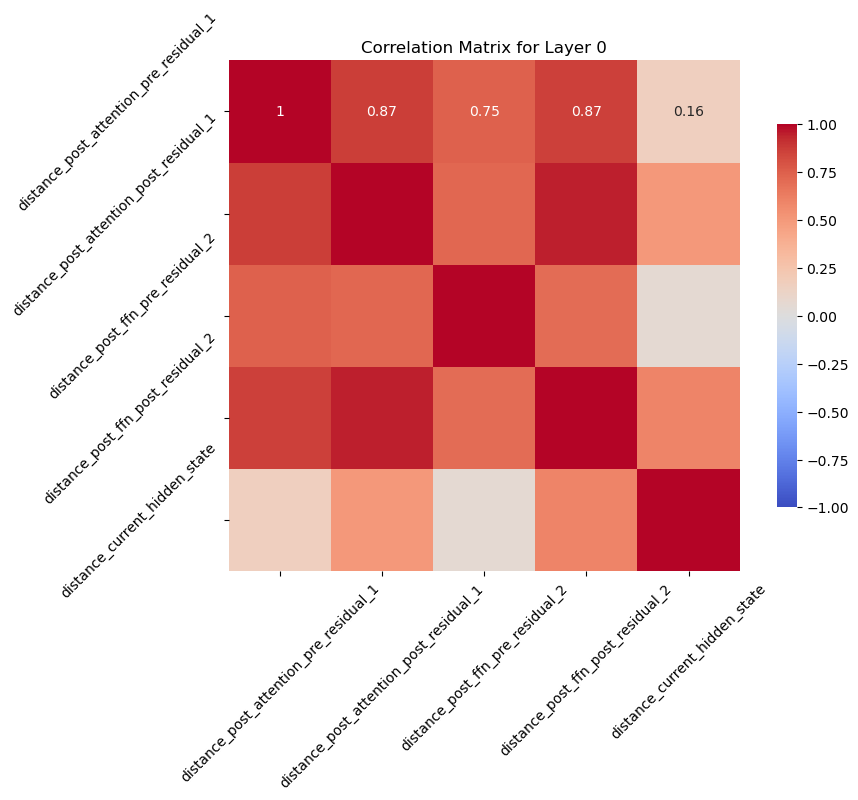

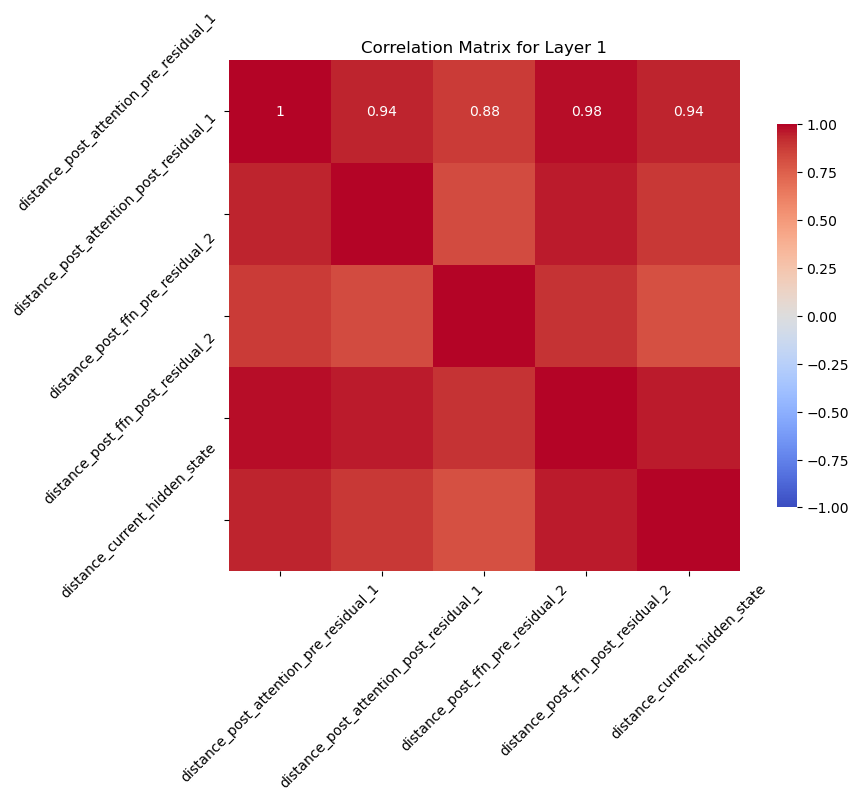

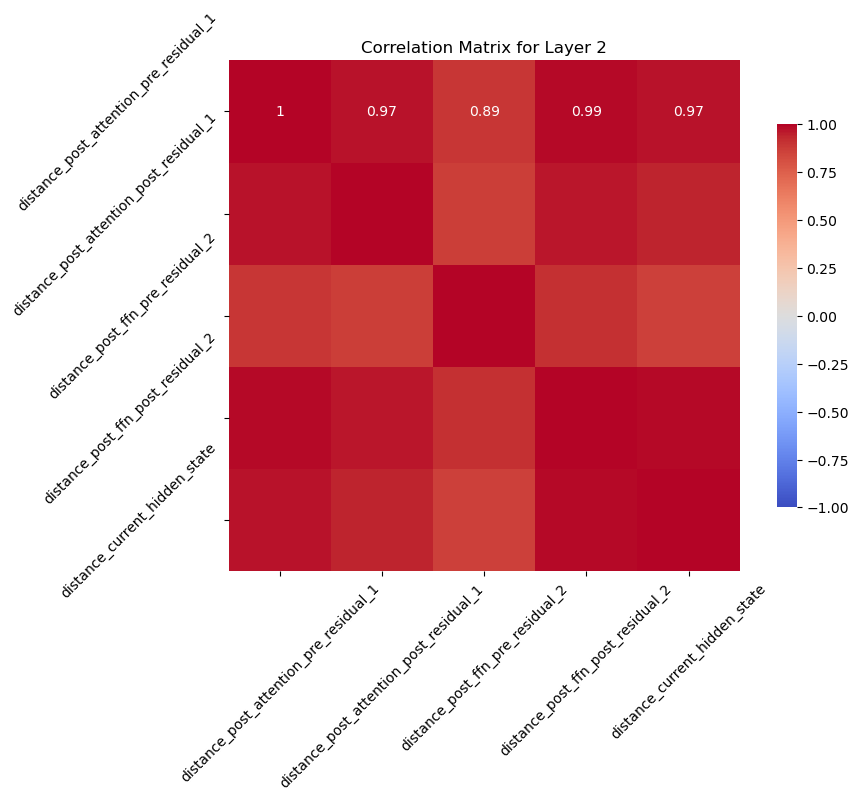

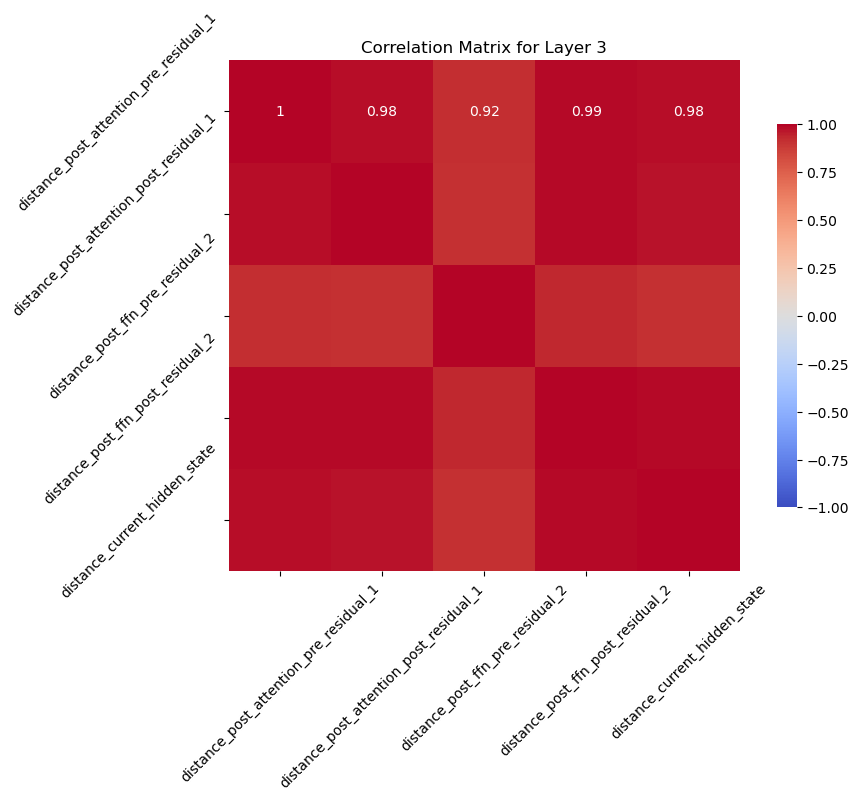

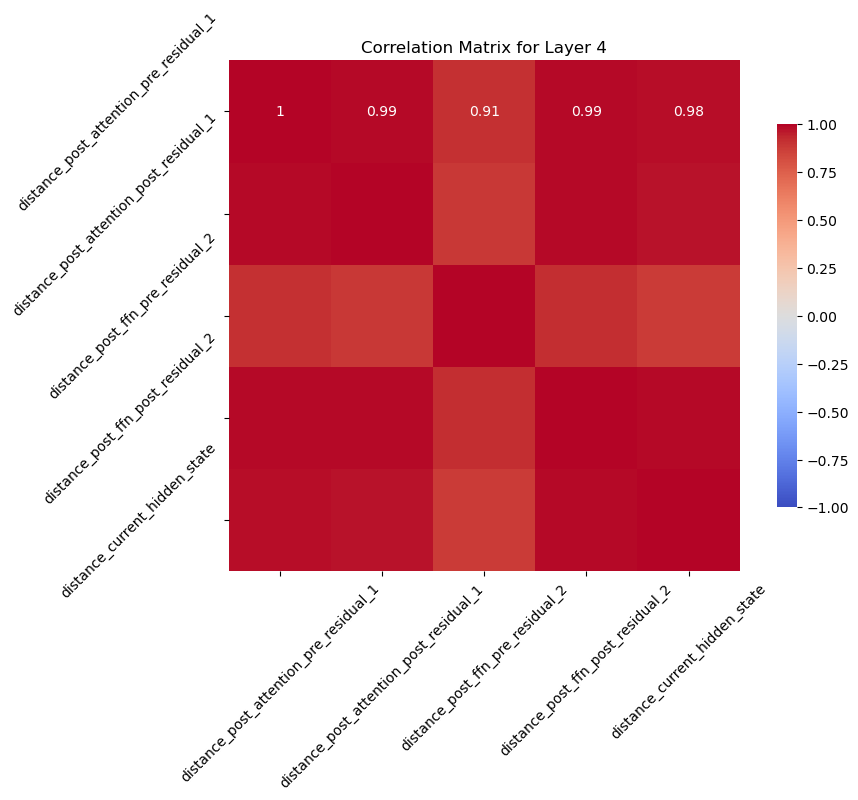

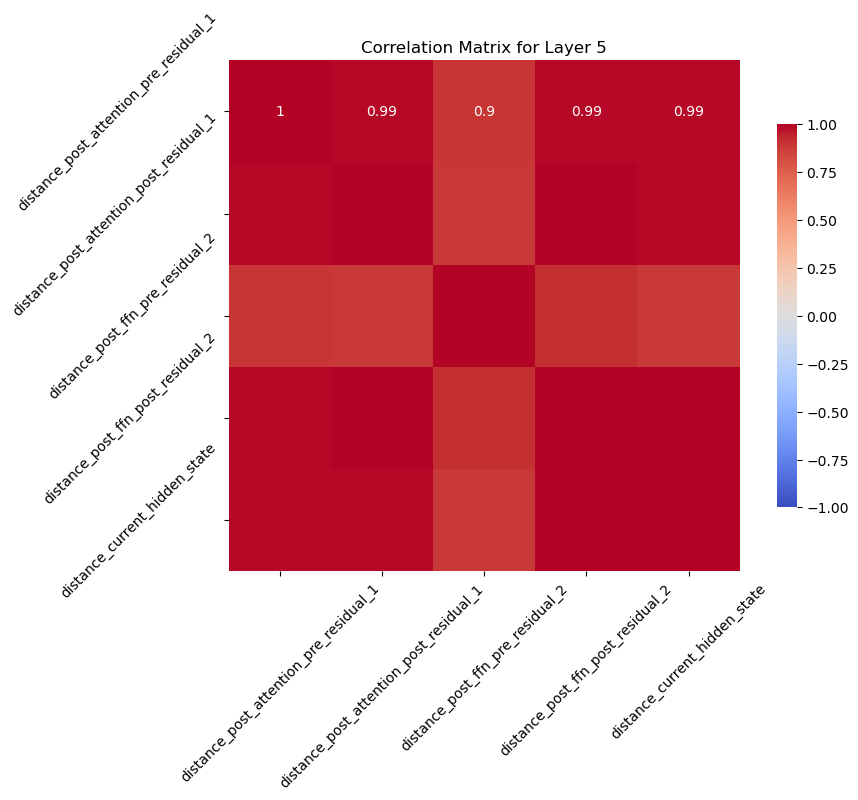

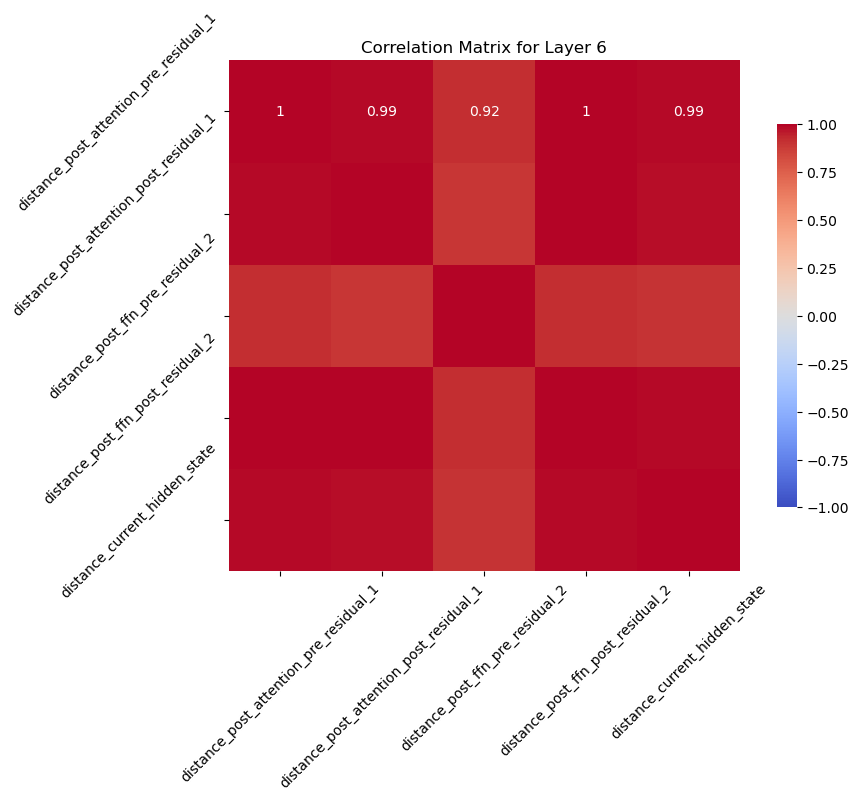

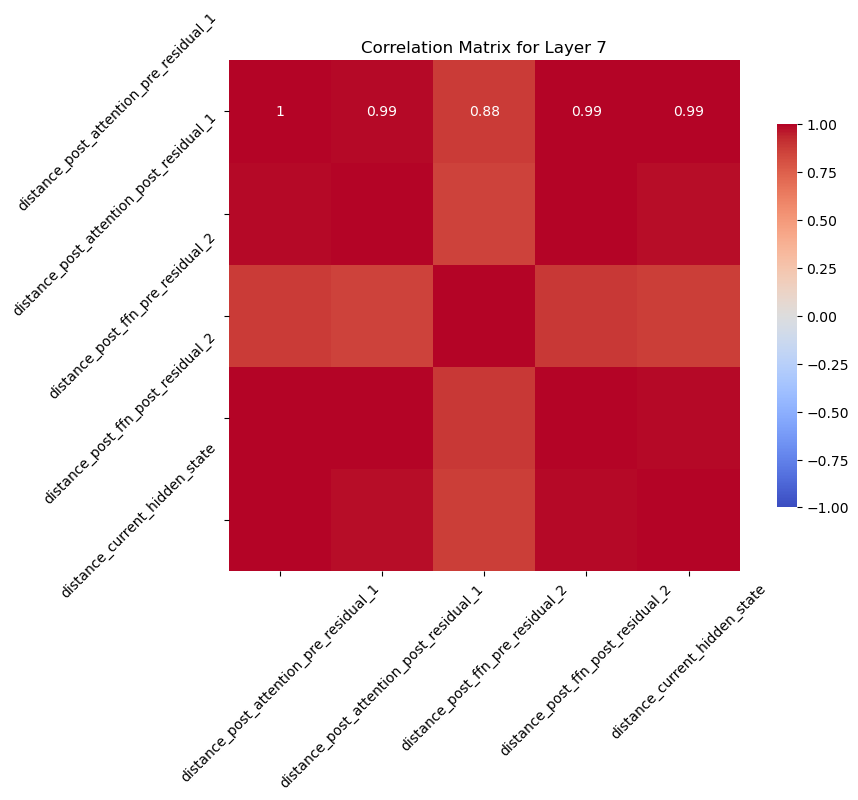

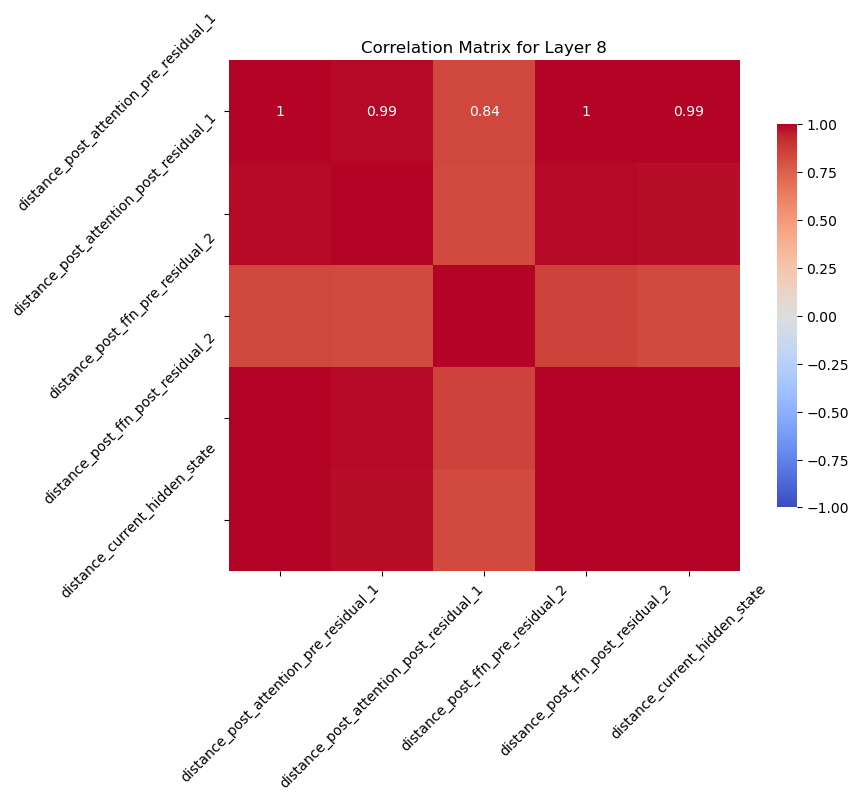

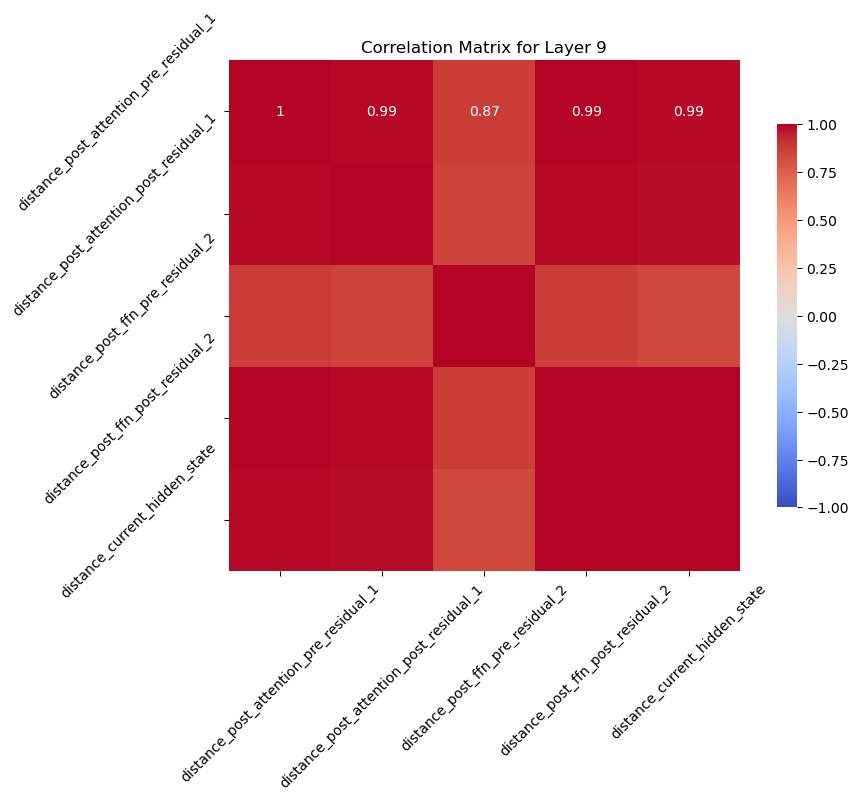

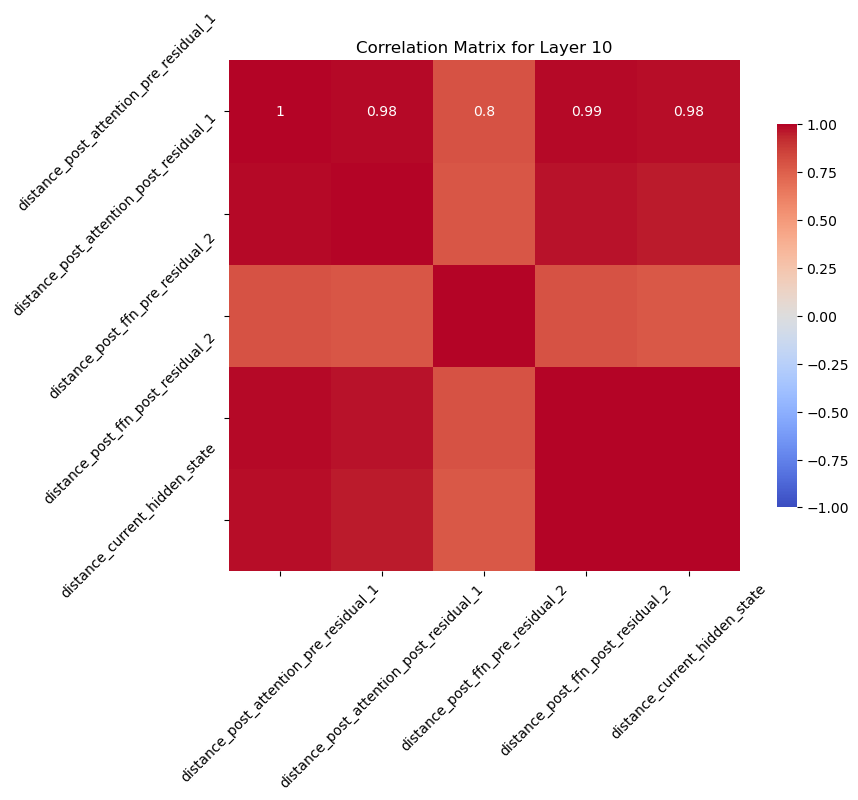

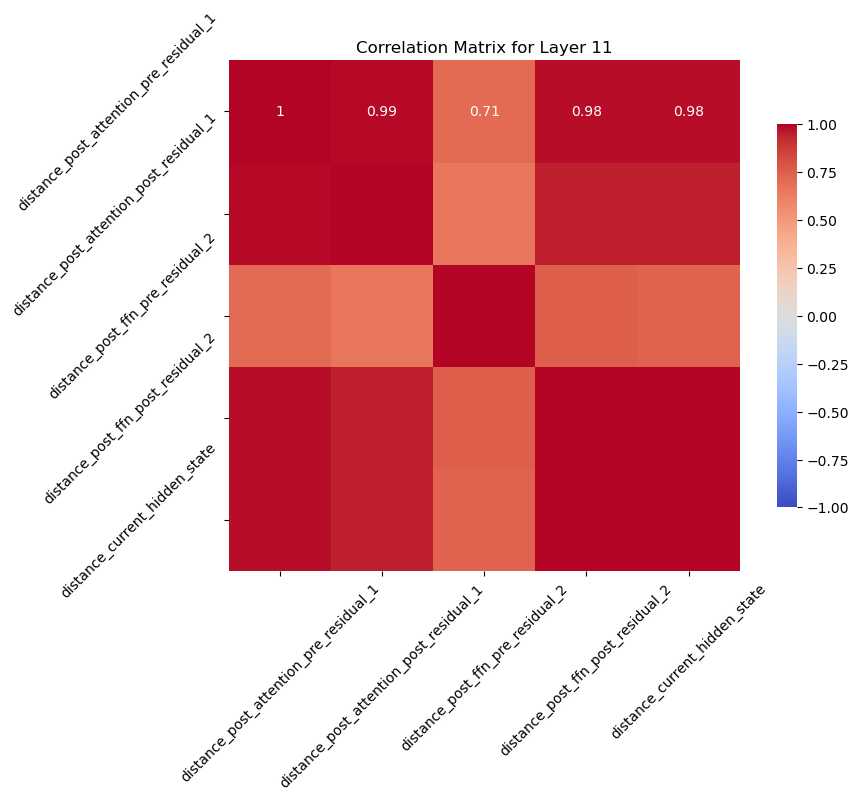

In [259]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# List of columns to include in the correlation matrices
columns_to_include = [
    'distance_post_attention_pre_residual_1',
    'distance_post_attention_post_residual_1',
    'distance_post_ffn_pre_residual_2',
    'distance_post_ffn_post_residual_2',
    'distance_current_hidden_state'
]

# List to store the correlation matrices
correlation_matrices = []

# Get unique layers
layers = df_results['Layer'].unique()

for layer in layers:
    # Filter the DataFrame for the current layer
    layer_df = df_results[df_results['Layer'] == layer]
    
    # Calculate the correlation matrix for the current layer
    corr_matrix = layer_df[columns_to_include].corr()
    
    # Append the correlation matrix to the list
    correlation_matrices.append((layer, corr_matrix))

    # Plot the correlation matrix using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .75})
    plt.title(f'Correlation Matrix for Layer {layer}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot
    # plt.savefig(f'correlation_matrix_layer_{layer}.png')
    # plt.close()


#### Each metric predicting `mean_relatedness`

In [260]:
# List of distance columns
distance_columns = [
    'distance_post_attention_pre_residual_1',
    'distance_post_attention_post_residual_1',
    'distance_post_ffn_pre_residual_2',
    'distance_post_ffn_post_residual_2',
    'distance_current_hidden_state'
]

# Function to calculate R^2
def calculate_r2(x, y):
    correlation_matrix = np.corrcoef(x, y)
    correlation_xy = correlation_matrix[0, 1]
    r_squared = correlation_xy ** 2
    return r_squared

# List to store results
r2_results = []

# Get unique layers
layers = df_results['Layer'].unique()

for layer in layers:
    # Filter the DataFrame for the current layer
    layer_df = df_results[df_results['Layer'] == layer]
    
    # Calculate R^2 for each distance column with respect to 'mean_relatedness'
    for col in distance_columns:
        r2 = calculate_r2(layer_df[col], layer_df['mean_relatedness'])
        r2_results.append({'Layer': layer, 'Metric': col, 'R2': r2})

# Convert R^2 results to DataFrame
r2_results_df = pd.DataFrame(r2_results)

In [261]:
r2_results_df['Metric'] = r2_results_df['Metric'].apply(lambda x: x.replace("distance_", ""))

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with 

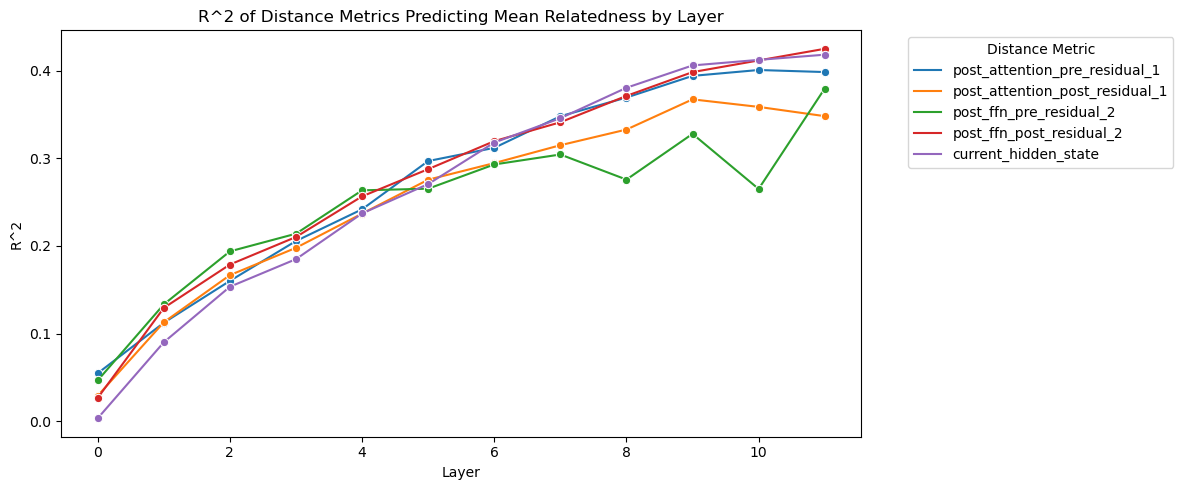

In [262]:
# Create the lineplot
plt.figure(figsize=(12, 5))
sns.lineplot(data=r2_results_df, x='Layer', y='R2', hue='Metric', marker='o')

# Add title and labels
plt.title('R^2 of Distance Metrics Predicting Mean Relatedness by Layer')
plt.xlabel('Layer')
plt.ylabel('R^2')
plt.legend(title='Distance Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

#### Residuals

In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming df is your DataFrame

# List of distance columns
distance_columns = [
    'distance_post_attention_pre_residual_1',
    'distance_post_attention_post_residual_1',
    'distance_post_ffn_pre_residual_2',
    'distance_post_ffn_post_residual_2',
    'distance_current_hidden_state'
]

# List to store results
residuals_results = []

# Get unique layers
layers = df_results['Layer'].unique()

for layer in layers:
    # Filter the DataFrame for the current layer
    layer_df = df_results[df_results['Layer'] == layer]
    
    # Calculate residuals for each distance column with respect to 'mean_relatedness'
    for col in distance_columns:
        X = layer_df[[col]].values
        y = layer_df['mean_relatedness'].values
        
        # Fit linear regression model
        model = LinearRegression().fit(X, y)
        predictions = model.predict(X)
        residuals = y - predictions
        
        for index, residual in enumerate(residuals):
            residuals_results.append({
                'Layer': layer,
                'Metric': col,
                'Residual': residual,
                'Same_sense': layer_df['Same_sense'].iloc[index]
            })

# Convert residuals results to DataFrame
residuals_df = pd.DataFrame(residuals_results)

In [269]:
residuals_df['Metric'] = residuals_df['Metric'].apply(lambda x: x.replace("distance_", ""))

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

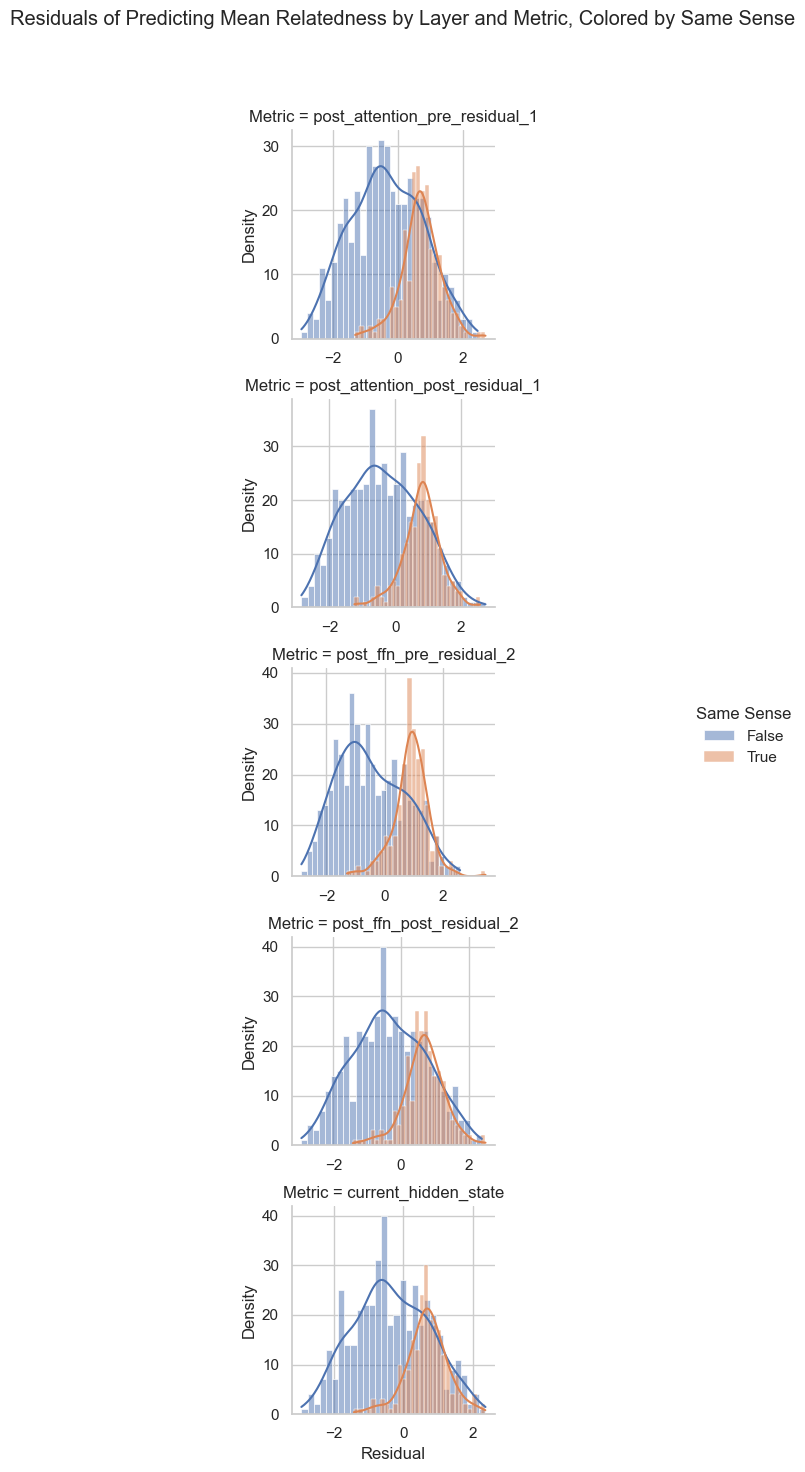

In [273]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create the plots
g = sns.FacetGrid(residuals_df[residuals_df['Layer']==10], row="Metric", hue="Same_sense", sharex=False, sharey=False)

# Map the density plots
g.map(sns.histplot, "Residual", kde=True, bins=30)

# Add titles and labels
g.set_axis_labels('Residual', 'Density')
g.add_legend(title='Same Sense')

# Adjust layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Residuals of Predicting Mean Relatedness by Layer and Metric, Colored by Same Sense')

# Show the plot
plt.show()
